In [1]:
%cd "/gscratch/xlab/alisaliu/pretokenization"

/mmfs1/gscratch/xlab/alisaliu/pretokenization


/gscratch/cse/alisaliu/miniconda3/envs/playground/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import json
import re
import os
from pathlib import Path
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from utils import read_json
import plot_utils

In [3]:
def get_results(config=None, tokenizer_dir=None, eval_dataset=None):
    if config:
        if config['pretok_setting'] == 'pretok':
            tokenizer_dir = Path(f"tokenizer_json/{config['train_dataset']}_{config['pretok_setting']}_{config['train_size']}_{config['vocab_size']}")
        elif config['pretok_setting'] == 'nopretok':
            tokenizer_dir = Path(f"tokenizer_json/{config['train_dataset']}_{config['pretok_setting']}_{config['train_size']}_{config['vocab_size']}_mw{config['max_multiword']}_colon")
        elif config['pretok_setting'] == 'extend':
            tokenizer_dir = Path(f"tokenizer_json/{config['train_dataset']}_{config['train_size']}_{config['num_inherit']}_extend_{config['vocab_size']}_mw{config['max_multiword']}_colon")
        eval_dataset = config['eval_dataset']
        print(tokenizer_dir)
    elif tokenizer_dir and eval_dataset:
        tokenizer_dir = Path(tokenizer_dir)
    else:
        print('Need either config or both tokenizer_dir and eval_dataset.')
        return None
    
    results = {}
    for filename in os.listdir(tokenizer_dir / eval_dataset):
        if filename.startswith('token_byte_counts'):
            match = re.search(r'\d+', filename)
            if match:
                vocab_size = int(match.group())
            else:
                vocab_size = len(read_json(tokenizer_dir / 'tokenizer.json')['model']['vocab'])
            
            token_byte_counts = read_json(tokenizer_dir / eval_dataset / filename)
            bytes_per_token = token_byte_counts['byte_count'] / token_byte_counts['token_count']
        elif filename == 'pretoken_byte_counts.json':
            token_byte_counts = read_json(tokenizer_dir / eval_dataset / filename)
            bytes_per_token = token_byte_counts['byte_count'] / token_byte_counts['pretoken_count']
            vocab_size = float('inf')
        
        results[vocab_size] = bytes_per_token
        
    return results

In [4]:
eval_dataset_name = 'olmo2'
vocab_size = '200K'
train_dataset_name = f'olmo2_p99_truncate'

compare_config = [{
    'train_dataset': train_dataset_name,
    'train_size': '10G',
    'pretok_setting': 'nopretok',
    'eval_dataset': eval_dataset_name,
    'vocab_size': vocab_size,
    'max_multiword': 4
}]

transition_points = []
for dirname in os.listdir('tokenizer_json'):
    match = re.match(rf'{train_dataset_name}_10G_(\d+)K_extend_{vocab_size}_mw4_colon', dirname)
    if match:
        num_inherit = int(match.group(1))
        transition_points.append(num_inherit)

transition_points.sort()
for num_inherit in transition_points:
    compare_config.append({
        'train_dataset': train_dataset_name,
        'train_size': '10G',
        'pretok_setting': 'extend',
        'num_inherit': f'{num_inherit}K',
        'eval_dataset': eval_dataset_name,
        'vocab_size': vocab_size,
        'max_multiword': 4
    })

compare_config.append(
    {
        'train_dataset': train_dataset_name,
        'train_size': '10G',
        'pretok_setting': 'pretok',
        'eval_dataset': eval_dataset_name,
        'vocab_size': vocab_size
    },
)

In [5]:
results = {}
for config in compare_config:
    if config['pretok_setting'] == 'extend':
        label = f"curriculum ({config['num_inherit']})"
    else:
        label = config['pretok_setting']
    
    try:
        results[label] = get_results(config)
    except FileNotFoundError:
        continue

tokenizer_json/olmo2_p99_truncate_nopretok_10G_200K_mw4_colon
tokenizer_json/olmo2_p99_truncate_10G_20K_extend_200K_mw4_colon
tokenizer_json/olmo2_p99_truncate_10G_40K_extend_200K_mw4_colon
tokenizer_json/olmo2_p99_truncate_10G_60K_extend_200K_mw4_colon
tokenizer_json/olmo2_p99_truncate_10G_80K_extend_200K_mw4_colon
tokenizer_json/olmo2_p99_truncate_10G_100K_extend_200K_mw4_colon
tokenizer_json/olmo2_p99_truncate_10G_120K_extend_200K_mw4_colon
tokenizer_json/olmo2_p99_truncate_10G_140K_extend_200K_mw4_colon
tokenizer_json/olmo2_p99_truncate_10G_160K_extend_200K_mw4_colon
tokenizer_json/olmo2_p99_truncate_10G_180K_extend_200K_mw4_colon
tokenizer_json/olmo2_p99_truncate_pretok_10G_200K


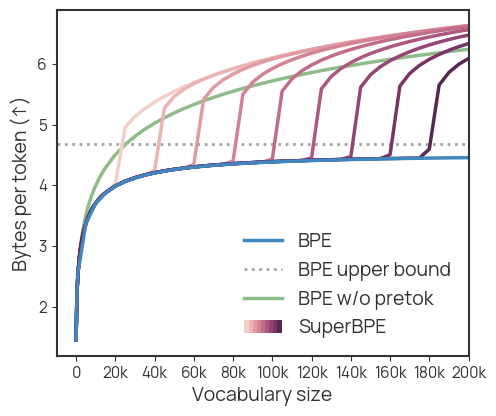

In [6]:
from matplotlib.colors import ListedColormap
from matplotlib.legend_handler import HandlerBase

fig, ax = plt.subplots(figsize=(4.8, 4))
legend_handles = [None] * 4
legend_labels = [""] * 4
curriculum_colors = []

ax.axhline(y=4.68, ls='dotted', color=sns.color_palette('deep')[-3], alpha=0.8, linewidth=2)
# palette = sns.color_palette('BuPu', n_colors=len(results)+2)[2:]

for i, (label, result) in enumerate(results.items()):
    if 'curriculum' in label:
        color = sns.cubehelix_palette(start=3.26, n_colors=len(results)-1, rot=0.3, hue=1.0)[i-1]
        curriculum_colors.append(color)
    elif label == 'pretok':
        color = "#4086BF"
    elif label == 'nopretok':
        color = "#8FBC8B"
    
    plot = sns.lineplot(result, color=color, label=label, ax=ax, linewidth=2.5)
    
    # Store handles and labels for discrete lines
    if 'curriculum' not in label:        
        if label == 'pretok':
            legend_handles[0] = plot.get_lines()[-1]
            legend_labels[0] = "BPE"
        elif label == 'nopretok':
            legend_handles[2] = plot.get_lines()[-1]
            legend_labels[2] = "BPE w/o pretok"

cmap = ListedColormap(curriculum_colors)

# Custom handler to draw gradient
class GradientHandler(HandlerBase):
    def __init__(self, cmap, num_stripes=20, **kw):
        super().__init__(**kw)
        self.cmap = cmap
        self.num_stripes = num_stripes
        
    def create_artists(self, legend, orig_handle,
                      xdescent, ydescent, width, height, fontsize, trans):
        stripes = []
        for i in range(self.num_stripes):
            color = self.cmap(i / (self.num_stripes - 1))
            s = mpatches.Rectangle(
                (xdescent + width * i / self.num_stripes, ydescent),
                width / self.num_stripes,
                height,
                color=color,
                transform=trans,
                linewidth=0
            )
            stripes.append(s)
        return stripes

# Create dummy patch for gradient legend entry
gradient_patch = mpatches.Patch(facecolor='none', edgecolor='none', linewidth=0)
legend_handles[-1] = gradient_patch
legend_labels[-1] = 'SuperBPE'

legend_handles[1] = plot.get_lines()[0]
legend_labels[1] = 'BPE upper bound'

# Create legend with custom handler
ax.legend(
    handles=legend_handles,
    labels=legend_labels,
    handler_map={mpatches.Patch: GradientHandler(cmap, num_stripes=20)},
    fontsize=14,
    frameon=False
)
# plot.set_xscale('log')

# xticks
xticks = range(0, 200001, 20000)
ax.set_xticks(xticks)
ax.set_xticklabels([f"{tick//1000}k" if tick != 0 else "0" for tick in xticks])

ax.set_xlim(right=200000)

ax.set_xlabel('Vocabulary size')
ax.set_ylabel('Bytes per token (↑)')
plt.tight_layout(pad=0.1)
plt.savefig('plots/pretokenization_scaling.png', dpi=300)
plt.savefig('plots/pretokenization_scaling.pdf', dpi=300)

In [7]:
vocab_size=200000
for key in results:
    if vocab_size in results[key]:
        print(f'{key}: {results[key][vocab_size]}')

nopretok: 6.243093421824771
curriculum (20K): 6.610424339069447
curriculum (40K): 6.627940845521906
curriculum (60K): 6.633993188773049
curriculum (80K): 6.6340211791656865
curriculum (100K): 6.618049635756115
curriculum (120K): 6.566714270967322
curriculum (140K): 6.477883269243099
curriculum (160K): 6.337087825510061
curriculum (180K): 6.092017425484803
pretok: 4.456569482553065


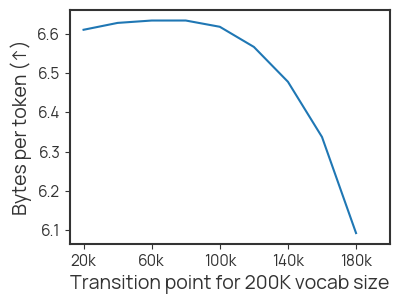

In [8]:
x, y = [], []

for key in results:
    if key.startswith('curriculum'):
        if vocab_size in results[key]:
            x.append(int(key.split('(')[-1].split(')')[0].replace('K', '000')))
            y.append(results[key][vocab_size])

fig, ax = plt.subplots(figsize=(6.4*3/5, 4.8*3/5))
sns.lineplot(x=x, y=y)
ax.set_xlim(right=vocab_size)

xticks = range(20000, vocab_size, 40000)
ax.set_xticks(xticks)
ax.set_xticklabels([f"{tick//1000}k" if tick != 0 else "0" for tick in xticks])

ax.set_xlabel(f'Transition point for {vocab_size // 1000}K vocab size')
ax.set_ylabel('Bytes per token (↑)')
plt.tight_layout(pad=0.1)
plt.savefig('plots/transition_point.png', dpi=300)
plt.savefig('plots/transition_point.pdf', dpi=300)

In [71]:
results = {}
for tokenizer in ['dolma_000', 'dolma_001', 'pile']:
    results[tokenizer] = {}
    for eval_dataset in ['dolma-000', 'dolma-001']:
        result = get_results(tokenizer_dir=f'tokenizer_json/debug_dolma/{tokenizer}', eval_dataset=eval_dataset)
        results[tokenizer][eval_dataset] = result

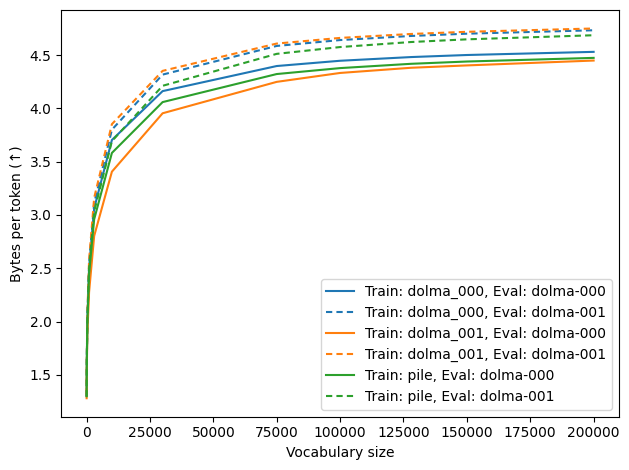

In [84]:
fig, ax = plt.subplots()
colors = sns.color_palette()
for tokenizer, color in zip(['dolma_000', 'dolma_001', 'pile'], colors):
    for eval_dataset, dashes in zip(['dolma-000', 'dolma-001'], [True, (3, 2)]):
        sns.lineplot(results[tokenizer][eval_dataset], label=f'Train: {tokenizer}, Eval: {eval_dataset}', color=color, dashes=dashes)
ax.set_xlabel('Vocabulary size')
ax.set_ylabel('Bytes per token (↑)')
plt.tight_layout()
plt.tight_layout()

In [22]:
tokenizer_dir = 'tokenizer_json/dolmino_10G_80K_extend_200K'
# tokenizer_dir = 'tokenizer_json/pile_pretok_10G_50K'
# tokenizer_dir = 'tokenizer_json/pile_nopretok_10G_50K'

In [23]:
results = {}
result = get_results(tokenizer_dir=tokenizer_dir, eval_dataset='dolmino')
results[0.0] = result

In [24]:
dropout_values = []
for dirname in os.listdir(tokenizer_dir):
    match = re.match(r'dolmino_drop([0-9]+(?:\.[0-9]+)?)', dirname)
    if match:
        p = match.group(1)
        dropout_values.append(p)

for dropout in dropout_values:
    result = get_results(tokenizer_dir=tokenizer_dir, eval_dataset=f'dolmino_drop{dropout}')
    results[float(dropout)] = result

In [25]:
color_palette = sns.cubehelix_palette(start=.5, rot=-.75, n_colors=len(dropout_values)+1)
# color_palette = sns.color_palette("Spectral", n_colors=len(dropout_values)+1)

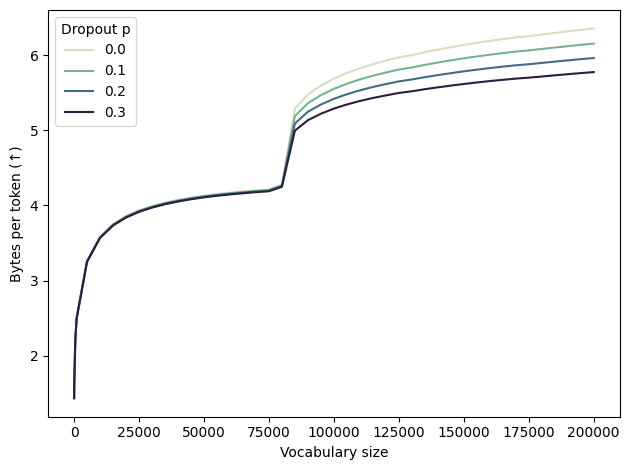

In [26]:
fig, ax = plt.subplots()
colors = sns.color_palette()
for tokenizer, color in zip(sorted(results.keys()), color_palette):
    sns.lineplot(results[tokenizer], label=tokenizer, color=color)
ax.set_xlabel('Vocabulary size')
ax.set_ylabel('Bytes per token (↑)')
ax.legend(title='Dropout p')
plt.tight_layout()
plt.tight_layout()
plt.tight_layout()
plt.savefig('plots/pretokenization_scaling.png', dpi=300)

In [29]:
p = []
bpt = []
for dropout in sorted(results.keys()):
    p.append(dropout)
    bpt.append(results[dropout][200000])

In [30]:
{x: y for x, y in zip(p, bpt)}

{0.0: 6.35539739400616,
 0.1: 6.15493741478066,
 0.2: 5.962126082952384,
 0.3: 5.775101259614844}

Text(0.5, 0, 'Dropout p')

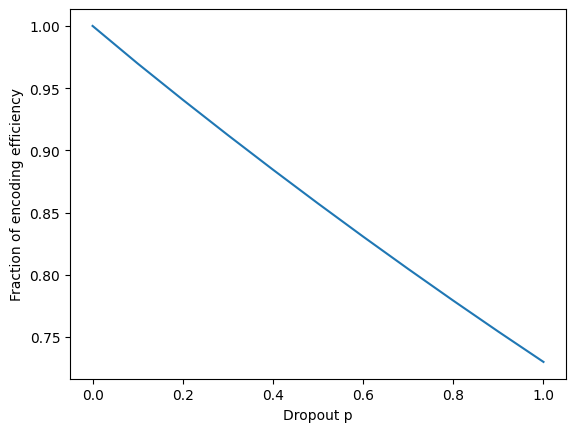

In [37]:
fig, ax = plt.subplots()
sns.lineplot(x=p, y=bpt)
ax.set_ylabel('Fraction of encoding efficiency')
ax.set_xlabel('Dropout p')

In [231]:
tokenizers = ['oscar_nopretok_10G_en_1.0_50K', 'oscar_nopretok_10G_fr_1.0_50K', 'oscar_pretok_10G_en_0.5_fr_0.5_50K', 'oscar_nopretok_10G_en_0.5_fr_0.5_50K']
readable_names = {
    'oscar_nopretok_10G_en_1.0_50K': 'nopretok_en',
    'oscar_nopretok_10G_fr_1.0_50K': 'nopretok_fr',
    'oscar_pretok_10G_en_0.5_fr_0.5_50K': 'pretok_mixed', 
    'oscar_nopretok_10G_en_0.5_fr_0.5_50K': 'nopretok_mixed'
}

In [232]:
results = {}
for tokenizer in tokenizers:
    results[tokenizer] = {}
    for lang_code in ['en', 'fr']:
        if os.path.exists(f'tokenizer_json/{tokenizer}/oscar_{lang_code}'):
            result = get_results(tokenizer_dir=f'tokenizer_json/{tokenizer}', eval_dataset=f'oscar_{lang_code}')
            results[tokenizer][lang_code] = result

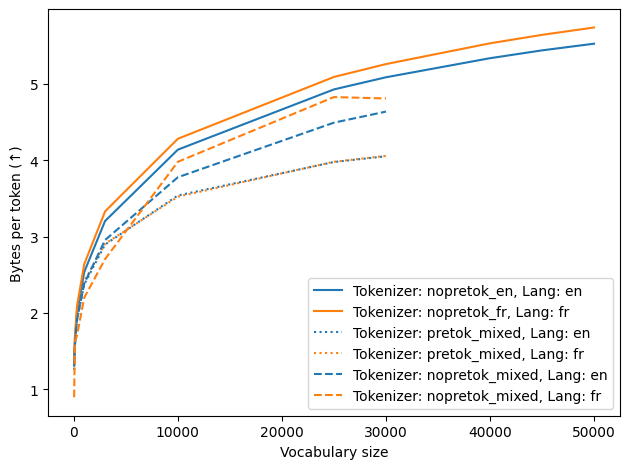

In [233]:
fig, ax = plt.subplots()
colors = sns.color_palette()
for tokenizer, linestyle in zip(tokenizers, ['solid', 'solid', 'dotted', 'dashed']):
    for lang_code, color in zip(['en', 'fr'], colors): 
        if lang_code in results[tokenizer]:
            sns.lineplot(
                results[tokenizer][lang_code],
                label=f"Tokenizer: {readable_names[tokenizer]}, Lang: {lang_code}",
                color=color,
                linestyle=linestyle
            )
        
ax.set_xlabel('Vocabulary size')
ax.set_ylabel('Bytes per token (↑)')
plt.tight_layout()
plt.tight_layout()

In [155]:
eval_dataset = 'dolma'
results = {}
tokenizer_dir_base = 'tokenizer_json/pile_pretok_10G_200K'
for i in range(1,5):
    if i > 0:
        tokenizer_dir = Path(tokenizer_dir_base + f"_np{i}")
        label = read_json(tokenizer_dir / "tokenizer.json")['pre_tokenizer']['pretokenizers'][1]['pattern']['Regex'].replace('(?=(\\d{3})+(?!\\d))|', '')
    else:
        label = "'s|'t|'re|'ve|'m|'ll|'d| ?\p{L}+| ?\p{N}+| ?[^\s\p{L}\p{N}]+|\s+(?!\S)|\s+"
    
    results[label] = get_results(tokenizer_dir=tokenizer_dir, eval_dataset=eval_dataset)

) missing from current font.onda3/envs/playground/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 13 (
  func(*args, **kwargs)
) missing from current font.onda3/envs/playground/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


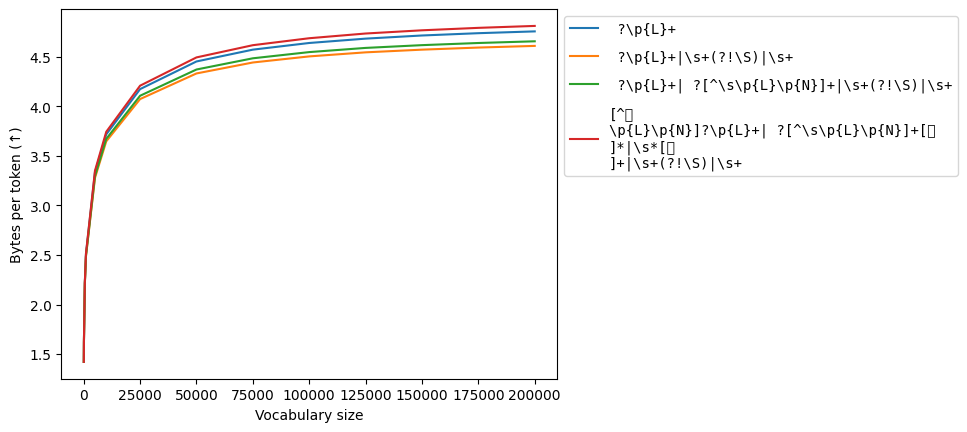

In [156]:
fig, ax = plt.subplots()
color_palette = sns.color_palette()
for tokenizer, color in zip(sorted(results.keys(), key=len), color_palette):
    sns.lineplot(results[tokenizer], label=tokenizer, color=color)
ax.set_xlabel('Vocabulary size')
ax.set_ylabel('Bytes per token (↑)')
from matplotlib import font_manager
ax.legend(prop=font_manager.FontProperties(family='monospace'), bbox_to_anchor=(1,1), fontsize=6, labelspacing=1.0)

# plt.tight_layout()
# plt.savefig('plots/pretokenization_scaling.png', dpi=300)

In [7]:
eval_dataset = 'dolma'
results = {}
tokenizer_dir_base = 'tokenizer_json/old_12072024/pile_pretok_10G_200K'
for i in range(1,5):
    if i == 0:
        tokenizer_dir = tokenizer_dir_base
    else:
        tokenizer_dir = Path(tokenizer_dir_base + f"_np{i}")

    regex = read_json(Path(tokenizer_dir) / "tokenizer.json")['pre_tokenizer']['pretokenizers'][1]['pattern']['Regex'].replace('(?=(\\d{3})+(?!\\d))|', '')
    results[f'np{i}'] = get_results(tokenizer_dir=tokenizer_dir, eval_dataset=eval_dataset)

for i in range(1,5):
    if i == 0:
        tokenizer_dir = 'tokenizer_json/old_12072024/pile_10G_100K_extend_200K'
    else:
        tokenizer_dir = f'tokenizer_json/old_12072024/pile_10G_100K_np{i}_extend_200K'
    results[f'np{i}_extend'] = get_results(tokenizer_dir=tokenizer_dir, eval_dataset=eval_dataset)

# results['np4_extend_norightĠ'] = get_results(tokenizer_dir="tokenizer_json/old_12072024/pile_10G_100K_np4_extend_200K_norightĠ", eval_dataset=eval_dataset)

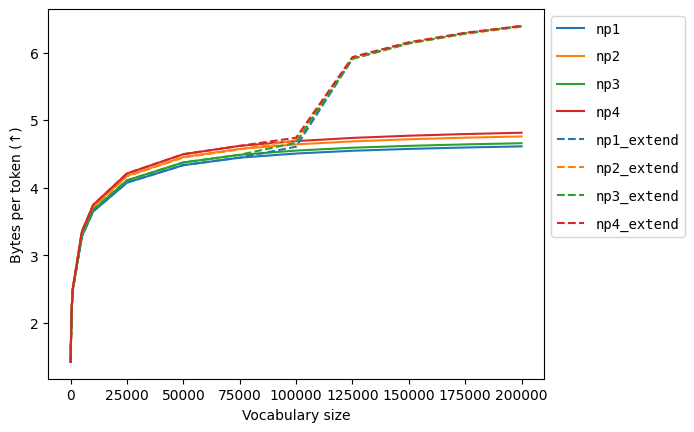

In [8]:
fig, ax = plt.subplots()
color_palette = sns.color_palette()
for tokenizer, color in zip(results.keys(), color_palette[:len(results)//2]*2 + [color_palette[:len(results)][-1]]):
    linestyle = '--' if 'extend' in tokenizer else None
    sns.lineplot(results[tokenizer], label=tokenizer, color=color, linestyle=linestyle)
ax.set_xlabel('Vocabulary size')
ax.set_ylabel('Bytes per token (↑)')
from matplotlib import font_manager
ax.legend(prop=font_manager.FontProperties(family='monospace'), bbox_to_anchor=(1,1), fontsize=6, labelspacing=1.0)

# plt.tight_layout()
# plt.savefig('plots/pretokenization_scaling.png', dpi=300)

In [13]:
for i in range(1, 5):
    print(results[f'np{i}_extend'][200000]/results[f'np{i}'][200000])
print(results['np4_extend_norightĠ'][200000]/results['np4'][200000])

1.386007170221434
1.3415464230369898
1.372130307822456
1.3284763162294029
1.3284763162294029


In [60]:
results = {}
tokenizer_dir = 'tokenizer_json/olmo2_p99_truncate_10G_80K_extend_200K_noRspace'
results['extend_noRspace'] = get_results(tokenizer_dir=tokenizer_dir, eval_dataset='olmo2')
tokenizer_dir = 'tokenizer_json/olmo2_p99_truncate_10G_80K_extend_200K'
results['extend'] = get_results(tokenizer_dir=tokenizer_dir, eval_dataset='olmo2')

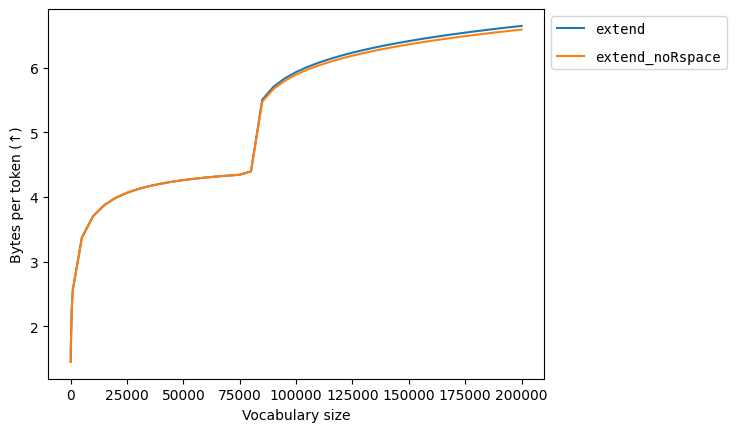

In [61]:
fig, ax = plt.subplots()
color_palette = sns.color_palette()
for tokenizer, color in zip(sorted(results.keys(), key=len), color_palette):
    sns.lineplot(results[tokenizer], label=tokenizer, color=color)
ax.set_xlabel('Vocabulary size')
ax.set_ylabel('Bytes per token (↑)')
from matplotlib import font_manager
ax.legend(prop=font_manager.FontProperties(family='monospace'), bbox_to_anchor=(1,1), fontsize=6, labelspacing=1.0)

In [62]:
vocab_size = 200000
for key in results:
    if vocab_size in results[key]:
        print(f'{key}: {results[key][vocab_size]}')

extend_noRspace: 6.59128873266187
extend: 6.647817975404642


In [60]:
results['pretok'][200000]/results['extend'][200000]

0.6874168957581956

In [89]:
results = {}
# tokenizer_dir = 'tokenizer_json/dolmino_pretok_10G_200K'
tokenizer_dir = "tokenizer_json/dolmino_10G_80K_extend_200K"

random_seeds = []
for dirname in os.listdir(tokenizer_dir):
    match = re.match(rf'dolmino-(\d+)', dirname)
    if match:
        random_seeds.append(int(match.group(1)))

for random_seed in random_seeds:
    results[random_seed] = get_results(tokenizer_dir=tokenizer_dir, eval_dataset=f'dolmino-{random_seed}')

results[5] = get_results(tokenizer_dir=tokenizer_dir, eval_dataset='dolmino')

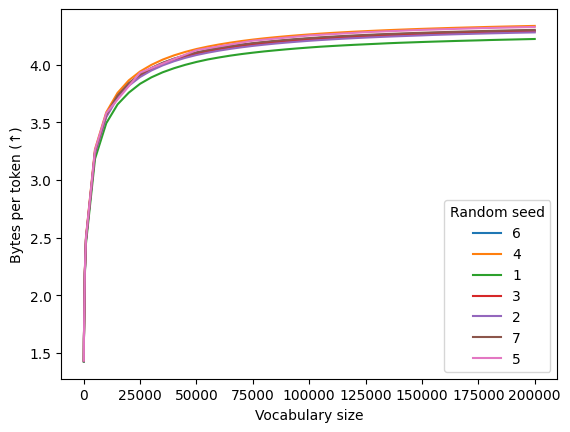

In [90]:
fig, ax = plt.subplots()
color_palette = sns.color_palette()
for tokenizer, color in zip(results, color_palette):
    sns.lineplot(results[tokenizer], label=tokenizer, color=color)
ax.set_xlabel('Vocabulary size')
ax.set_ylabel('Bytes per token (↑)')
ax.legend(title='Random seed')

In [88]:
sorted_keys = sorted(results[6], key=results[6].get)
for k in sorted_keys:
    print(f"{k}: {results[6][k]}")

50: 1.432542547022199
100: 1.6257685881967021
500: 2.1967838122796914
1000: 2.4823746004205387
5000: 3.2405828088371744
10000: 3.5631522468217227
15000: 3.7324470433788393
20000: 3.8408508867420452
25000: 3.9170410656122203
30000: 3.9741547680207967
35000: 4.019041834383292
40000: 4.055359172759935
45000: 4.08464310171524
50000: 4.1089832700157505
55000: 4.129948942597609
60000: 4.148336120012692
65000: 4.1639217747334145
70000: 4.1774817142643785
75000: 4.189165821003253
80000: 4.252219281080262
85000: 5.2812761743348
90000: 5.482801971692348
95000: 5.607728522101149
100000: 5.705514545267923
105000: 5.794102153288836
110000: 5.8589404771722675
115000: 5.920336847274278
120000: 5.969653505192494
125000: 6.0179994994950174
130000: 6.13634510878528
135000: 6.174942493378054
140000: 6.209478110130434
145000: 6.242030020019689
150000: 6.272826974179714
155000: 6.301119207944275
160000: 6.3275253147203525
170000: 6.375506304457662
175000: 6.392949262287857
180000: 6.414340618292404
185000:

In [84]:
vocab_size = 200000
for key in results:
    if vocab_size in results[key]:
        print(f'{key}: {results[key][vocab_size]}')

6: 6.496501887097372
10: 6.390326783418789
4: 6.371292119831721
9: 6.337537835496974
1: 6.137161797967224
8: 6.352990391966038
3: 6.45864795425846
2: 6.29475396966699
7: 6.341131371342899
5: 6.35539739400616


In [48]:
from tokenizers import Tokenizer
tokenizer = Tokenizer.from_file(str(Path(tokenizer_dir) / "tokenizer.json"))

In [52]:
vocab = tokenizer.get_vocab()

In [54]:
tokenizer_json = read_json(Path(tokenizer_dir) / "tokenizer.json")

In [91]:
'ĠstatesĠofĠtheĠUnitedĠStates.ĠComplianceĠrequirementsĠareĠnotĠuniformĠandĠitĠtakesĠaĠconsiderableĠeffort,ĠmuchĠpaperworkĠandĠmanyĠfeesĠtoĠmeetĠandĠkeepĠupĠwithĠtheseĠrequirements.ĠWeĠdoĠnotĠsolicitĠdonationsĠinĠlocationsĠwhereĠweĠhaveĠnotĠreceivedĠwrittenĠconfirmationĠofĠcompliance.ĠToĠSENDĠDONATIONSĠorĠdetermineĠtheĠstatusĠofĠcomplianceĠforĠanyĠparticularĠstateĠvisitĠWhileĠweĠcannotĠandĠdoĠnotĠsolicitĠcontributionsĠfromĠstatesĠwhereĠweĠhaveĠnotĠmetĠtheĠsolicitationĠrequirements,ĠweĠknowĠofĠnoĠprohibitionĠagainstĠacceptingĠunsolicitedĠdonationsĠfromĠdonorsĠinĠsuchĠstatesĠwhoĠapproachĠusĠwithĠoffersĠtoĠdonate.ĠInternationalĠdonationsĠareĠgratefullyĠaccepted,ĠbutĠweĠcannotĠmakeĠanyĠstatementsĠconcerningĠtaxĠtreatmentĠofĠdonationsĠreceivedĠfromĠoutsideĠtheĠUnitedĠStates.ĠU.S.ĠlawsĠaloneĠswampĠourĠsmallĠstaff.ĠPleaseĠcheckĠtheĠProjectĠGutenbergĠWebĠpagesĠforĠcurrentĠdonationĠmethodsĠandĠaddresses.ĠDonationsĠareĠacceptedĠinĠaĠnumberĠofĠotherĠways'.replace("Ġ", " ")

' states of the United States. Compliance requirements are not uniform and it takes a considerable effort, much paperwork and many fees to meet and keep up with these requirements. We do not solicit donations in locations where we have not received written confirmation of compliance. To SEND DONATIONS or determine the status of compliance for any particular state visit While we cannot and do not solicit contributions from states where we have not met the solicitation requirements, we know of no prohibition against accepting unsolicited donations from donors in such states who approach us with offers to donate. International donations are gratefully accepted, but we cannot make any statements concerning tax treatment of donations received from outside the United States. U.S. laws alone swamp our small staff. Please check the Project Gutenberg Web pages for current donation methods and addresses. Donations are accepted in a number of other ways'

In [87]:
list(tokenizer_json['model']['vocab'].keys()).index('ĠtoĠestimateĠtheĠtarget')

129038

In [68]:
sus_merges = list(tokenizer_json['model']['vocab'].keys())[125000:130000]
sorted(sus_merges, key=len, reverse=True)

["ownershipĠ\\<S>\\<^sub>s\\<^sub>b'Ġts\\<^sub>s\\<^sub>b'Ġ\\<and>Ġvalid_readsĠm\\<^sub>s\\<^sub>b'Ġts\\<^sub>s\\<^sub>b'Ġ\\<and>Ġvalid_historyĠprogram_stepĠts\\<^sub>s\\<^sub>b'Ġ\\<and>Ġvalid_sharingĠ\\<S>\\<^sub>s\\<^sub>b'Ġts\\<^sub>s\\<^sub>b'Ġ\\<and>Ġtmps_distinctĠts\\<^sub>s\\<^sub>b'Ġ\\<and>Ġvalid_data_dependencyĠts\\<^sub>s\\<^sub>b'Ġ\\<and>Ġvalid_sopsĠts\\<^sub>s\\<^sub>b'Ġ\\<and>Ġload_tmps_freshĠts\\<^sub>s\\<^sub>b'Ġ\\<and>Ġenough_flushsĠts\\<^sub>s\\<^sub>b'Ġ\\<and>Ġvalid_program_historyĠts\\<^sub>s\\<^sub>b'Ġ\\<and>ĠvalidĠts\\<^sub>s\\<^sub>b'Ġ\\<and>Ġ(\\<exists>ts'Ġ\\<S>'Ġm'.Ġ(ts,Ġm,Ġ\\<S>)Ġ\\<Rightarrow>\\<^sub>d\\<^sup>*Ġ(ts',Ġm',Ġ\\<S>')Ġ\\<and>Ġ(ts\\<^sub>s\\<^sub>b',Ġm\\<^sub>s\\<^sub>b',Ġ\\<S>\\<^sub>s\\<^sub>b')Ġ\\<sim>Ġ(ts',Ġm',Ġ\\<S>'))Ċ",
 "ownershipĠ\\<S>\\<^sub>s\\<^sub>b'Ġts\\<^sub>s\\<^sub>b'Ġ\\<and>Ġvalid_readsĠm\\<^sub>s\\<^sub>b'Ġts\\<^sub>s\\<^sub>b'Ġ\\<and>Ġvalid_historyĠprogram_stepĠts\\<^sub>s\\<^sub>b'Ġ\\<and>Ġvalid_sharingĠ\\<S>\\<^sub>s\\<^sub>b'Ġt

In [54]:
results = {}
percentiles = [60, 80, 90, 95, 99]
for percentile in percentiles:
    for strat in ["remove", "truncate"]:
        # pretok
        try:
            tokenizer_name = f'olmo2_p{percentile}_{strat}_pretok_10G_200K'
            tokenizer_dir = Path("tokenizer_json") / tokenizer_name
            results[tokenizer_name] = get_results(tokenizer_dir=tokenizer_dir, eval_dataset='olmo2')
        except FileNotFoundError:
            continue
        # ptc
        try:
            tokenizer_name = f'olmo2_p{percentile}_{strat}_10G_80K_extend_200K'
            tokenizer_dir = Path("tokenizer_json") / tokenizer_name
            results[tokenizer_name] = get_results(tokenizer_dir=tokenizer_dir, eval_dataset='olmo2')
        except FileNotFoundError:
            continue

tokenizer_name = 'olmo2_pretok_10G_200K'
tokenizer_dir = Path("tokenizer_json") / tokenizer_name
results[tokenizer_name] = get_results(tokenizer_dir=tokenizer_dir, eval_dataset='olmo2')

tokenizer_name = 'olmo2_10G_80K_extend_200K'
tokenizer_dir = Path("tokenizer_json") / tokenizer_name
results[tokenizer_name] = get_results(tokenizer_dir=tokenizer_dir, eval_dataset='olmo2')

In [55]:
vocab_size = 200000
for key in results:
    if vocab_size in results[key]:
        print(f'{key}: {results[key][vocab_size]}')

olmo2_p60_remove_pretok_10G_200K: 4.452950728207063
olmo2_p60_remove_10G_80K_extend_200K: 6.599090179477502
olmo2_p60_truncate_pretok_10G_200K: 4.4557283686039435
olmo2_p60_truncate_10G_80K_extend_200K: 6.6295002298878645
olmo2_p80_remove_pretok_10G_200K: 4.454328738494279
olmo2_p80_remove_10G_80K_extend_200K: 6.617825482210997
olmo2_p80_truncate_pretok_10G_200K: 4.456150275896529
olmo2_p80_truncate_10G_80K_extend_200K: 6.636585722464927
olmo2_p90_remove_pretok_10G_200K: 4.455011970438964
olmo2_p90_remove_10G_80K_extend_200K: 6.62736181612618
olmo2_p90_truncate_pretok_10G_200K: 4.456434292748526
olmo2_p90_truncate_10G_80K_extend_200K: 6.640654470498219
olmo2_p95_remove_pretok_10G_200K: 4.455699740018831
olmo2_p95_remove_10G_80K_extend_200K: 6.633868423150505
olmo2_p99_remove_pretok_10G_200K: 4.456465532443305
olmo2_p99_remove_10G_80K_extend_200K: 6.6441012171149625
olmo2_p99_truncate_pretok_10G_200K: 4.456569482553065
olmo2_p99_truncate_10G_80K_extend_200K: 6.647817975404642
olmo2_pret

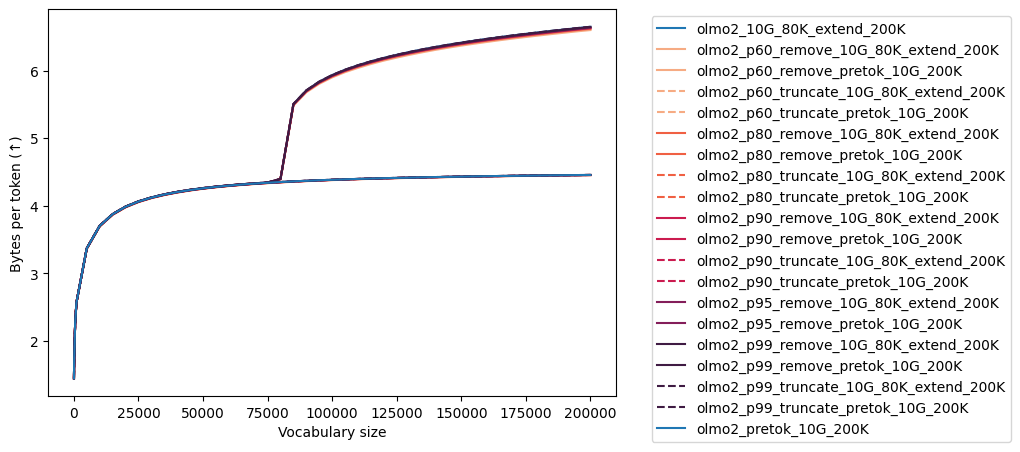

In [56]:
fig, ax = plt.subplots()
color_palette = sns.color_palette("rocket", n_colors=len(percentiles))[::-1]
for tokenizer_name in sorted(results.keys()):
    if "truncate" in tokenizer_name:
        linestyle = "dashed"
    else:
        linestyle = "solid"
    
    color = sns.color_palette()[0]
    for i, p in enumerate(percentiles):
        if f"p{p}" in tokenizer_name:
            color = color_palette[i]
    sns.lineplot(results[tokenizer_name], label=tokenizer_name, color=color, linestyle=linestyle)

ax.set_xlabel('Vocabulary size')
ax.set_ylabel('Bytes per token (↑)')
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig('plots/pretokenization_scaling.png', dpi=300)

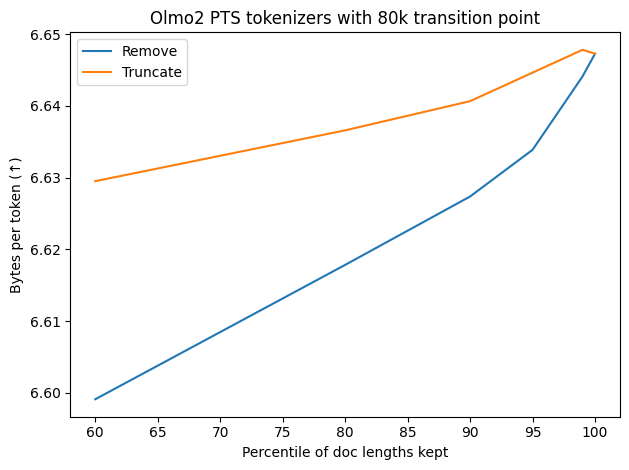

In [57]:
vocab_size = 200000

x, y = [], []
for p in percentiles:
    tokenizer_name = f'olmo2_p{p}_remove_10G_80K_extend_200K'
    if tokenizer_name in results and vocab_size in results[tokenizer_name]:
        x.append(p)
        y.append(results[tokenizer_name][vocab_size])
x.append(100)
y.append(results['olmo2_10G_80K_extend_200K'][vocab_size])

fig, ax = plt.subplots()
sns.lineplot(x=x, y=y, ax=ax, label="Remove")

x, y = [], []
for p in percentiles:
    tokenizer_name = f'olmo2_p{p}_truncate_10G_80K_extend_200K'
    if tokenizer_name in results and vocab_size in results[tokenizer_name]:
        x.append(p)
        y.append(results[tokenizer_name][vocab_size])
x.append(100)
y.append(results['olmo2_10G_80K_extend_200K'][vocab_size])
sns.lineplot(x=x, y=y, ax=ax, label="Truncate")

ax.set_title('Olmo2 PTS tokenizers with 80k transition point')
ax.set_xlabel(f'Percentile of doc lengths kept')
ax.set_ylabel('Bytes per token (↑)')
plt.tight_layout()
plt.savefig('plots/pretokenization_scaling.png', dpi=300)

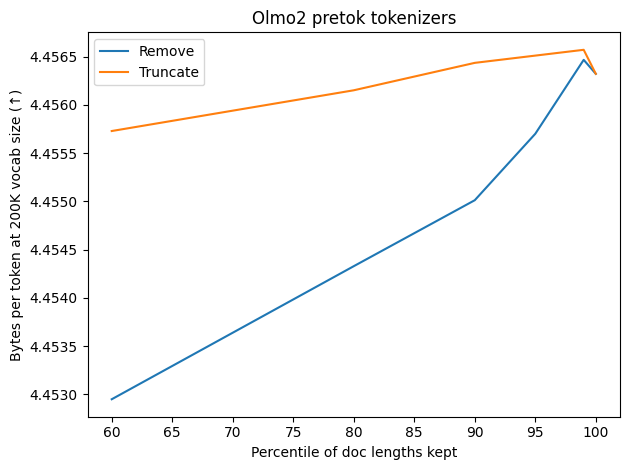

In [27]:
strat = "remove"
x, y = [], []
for p in percentiles:
    tokenizer_name = f'olmo2_p{p}_{strat}_pretok_10G_200K'
    if tokenizer_name in results:
        x.append(p)
        y.append(results[tokenizer_name][vocab_size])
x.append(100)
y.append(results['olmo2_pretok_10G_200K'][vocab_size])

fig, ax = plt.subplots()
sns.lineplot(x=x, y=y, ax=ax, label="Remove")

strat = "truncate"
x, y = [], []
for p in percentiles:
    tokenizer_name = f'olmo2_p{p}_{strat}_pretok_10G_200K'
    if tokenizer_name in results:
        x.append(p)
        y.append(results[tokenizer_name][vocab_size])
x.append(100)
y.append(results['olmo2_pretok_10G_200K'][vocab_size])
sns.lineplot(x=x, y=y, ax=ax, label="Truncate")

ax.set_xlabel(f'Percentile of doc lengths kept')
ax.set_ylabel('Bytes per token at 200K vocab size (↑)')
ax.set_title('Olmo2 pretok tokenizers')
plt.tight_layout()
plt.savefig('plots/pretokenization_scaling.png', dpi=300)

In [47]:
results = {}
percentiles = [60, 80, 90, 95, 99]
for percentile in percentiles:
    for strat in ["remove", "truncate"]:
        try:
            tokenizer_name = f'olmo2_p{percentile}_{strat}_10G_80K_extend_200K'
            tokenizer_dir = Path("tokenizer_json") / tokenizer_name
            results[tokenizer_name] = get_results(tokenizer_dir=tokenizer_dir, eval_dataset='olmo2')
        except FileNotFoundError:
            continue

tokenizer_name = 'dolmino_10G_80K_extend_200K'
tokenizer_dir = Path("tokenizer_json") / tokenizer_name
results[tokenizer_name] = get_results(tokenizer_dir=tokenizer_dir, eval_dataset='olmo2')

tokenizer_name = 'olmo2_10G_80K_extend_200K'
tokenizer_dir = Path("tokenizer_json") / tokenizer_name
results[tokenizer_name] = get_results(tokenizer_dir=tokenizer_dir, eval_dataset='olmo2')

In [48]:
vocab_size = 200000
for key in results:
    if vocab_size in results[key]:
        print(f'{key}: {results[key][vocab_size]}')

olmo2_p60_remove_10G_80K_extend_200K: 6.599090179477502
olmo2_p80_remove_10G_80K_extend_200K: 6.617825482210997
olmo2_p80_truncate_10G_80K_extend_200K: 6.636585722464927
olmo2_p90_remove_10G_80K_extend_200K: 6.62736181612618
olmo2_p90_truncate_10G_80K_extend_200K: 6.640654470498219
olmo2_p95_remove_10G_80K_extend_200K: 6.633868423150505
olmo2_p95_truncate_10G_80K_extend_200K: 6.643413744194636
olmo2_p99_remove_10G_80K_extend_200K: 6.6441012171149625
olmo2_p99_truncate_10G_80K_extend_200K: 6.647817975404642
dolmino_10G_80K_extend_200K: 6.585446771131082
olmo2_10G_80K_extend_200K: 6.647272539988845


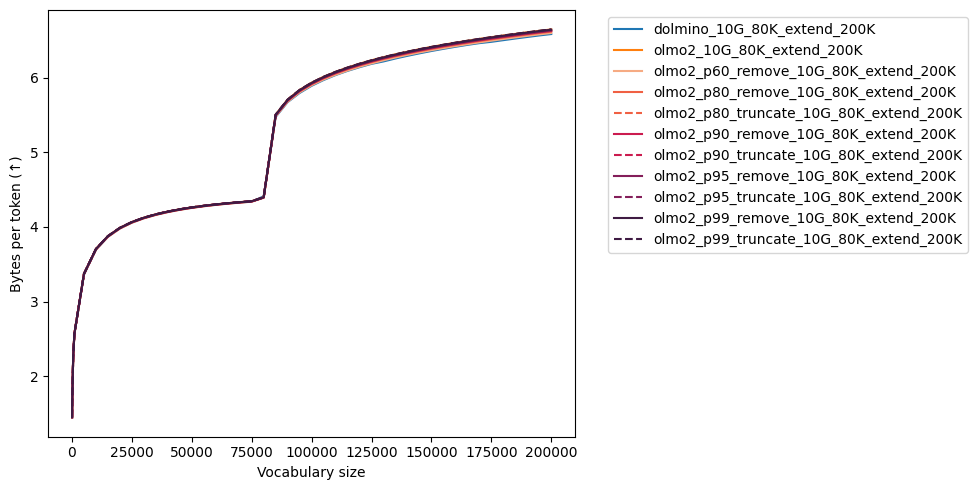

In [53]:
fig, ax = plt.subplots(figsize=(10, 5))
color_palette = sns.color_palette("rocket", n_colors=len(percentiles))[::-1]
for tokenizer_name in sorted(results.keys()):
    if "truncate" in tokenizer_name:
        linestyle = "dashed"
    else:
        linestyle = "solid"
    
    color = sns.color_palette()[1]
    for i, p in enumerate(percentiles):
        if f"p{p}" in tokenizer_name:
            color = color_palette[i]
        elif "dolmino" in tokenizer_name:
            color = sns.color_palette()[0]
    sns.lineplot(results[tokenizer_name], label=tokenizer_name, color=color, linestyle=linestyle)

ax.set_xlabel('Vocabulary size')
ax.set_ylabel('Bytes per token (↑)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('plots/pretokenization_scaling.png', dpi=300)

In [163]:
from constants import CODE_TO_LANG

In [370]:
vocab_size = '200K'
compare_config = []

for lang in ['en', 'fr', 'es', 'pt', 'it', 'de', 'ru', 'ja', 'zh']:
    eval_dataset_name = f'madlad/{lang}'
    train_dataset_name = f'madlad/{lang}'
    compare_config.append(
        {
            'train_dataset': train_dataset_name,
            'train_size': '10G',
            'pretok_setting': 'pretok',
            'eval_dataset': eval_dataset_name,
            'vocab_size': vocab_size
        },
    )

compare_config

[{'train_dataset': 'madlad/en',
  'train_size': '10G',
  'pretok_setting': 'pretok',
  'eval_dataset': 'madlad/en',
  'vocab_size': '200K'},
 {'train_dataset': 'madlad/fr',
  'train_size': '10G',
  'pretok_setting': 'pretok',
  'eval_dataset': 'madlad/fr',
  'vocab_size': '200K'},
 {'train_dataset': 'madlad/es',
  'train_size': '10G',
  'pretok_setting': 'pretok',
  'eval_dataset': 'madlad/es',
  'vocab_size': '200K'},
 {'train_dataset': 'madlad/pt',
  'train_size': '10G',
  'pretok_setting': 'pretok',
  'eval_dataset': 'madlad/pt',
  'vocab_size': '200K'},
 {'train_dataset': 'madlad/it',
  'train_size': '10G',
  'pretok_setting': 'pretok',
  'eval_dataset': 'madlad/it',
  'vocab_size': '200K'},
 {'train_dataset': 'madlad/de',
  'train_size': '10G',
  'pretok_setting': 'pretok',
  'eval_dataset': 'madlad/de',
  'vocab_size': '200K'},
 {'train_dataset': 'madlad/ru',
  'train_size': '10G',
  'pretok_setting': 'pretok',
  'eval_dataset': 'madlad/ru',
  'vocab_size': '200K'},
 {'train_data

In [371]:
results = {}

# Read results and come up with labels
for config in compare_config:
    lang = config['train_dataset'].split('/')[-1]
    try:
        results[lang] = get_results(config)
    except FileNotFoundError:
        continue

tokenizer_json/madlad/en_pretok_10G_200K
tokenizer_json/madlad/fr_pretok_10G_200K
tokenizer_json/madlad/es_pretok_10G_200K
tokenizer_json/madlad/pt_pretok_10G_200K
tokenizer_json/madlad/it_pretok_10G_200K
tokenizer_json/madlad/de_pretok_10G_200K
tokenizer_json/madlad/ru_pretok_10G_200K
tokenizer_json/madlad/ja_pretok_10G_200K
tokenizer_json/madlad/zh_pretok_10G_200K


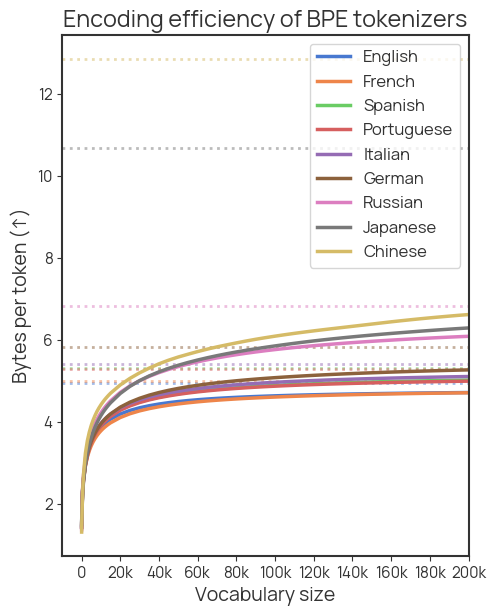

In [372]:
from matplotlib.colors import ListedColormap
from matplotlib.legend_handler import HandlerBase

fig, ax = plt.subplots(figsize=(4.8, 6))
palette = sns.color_palette('muted')

for i, (label, result) in enumerate(results.items()):
    upper_bound = result[float('inf')]
    color = palette[i % len(palette)]
    ax.axhline(y=upper_bound, ls='dotted', color=color, alpha=0.5, linewidth=2)
    
    plot = sns.lineplot(result, color=color, label=CODE_TO_LANG[label], ax=ax, linewidth=2.5)

# plot.set_xscale('log')
# xticks
xticks = range(0, 200001, 20000)
ax.set_xticks(xticks)
ax.set_xticklabels([f"{tick//1000}k" if tick != 0 else "0" for tick in xticks])

ax.set_xlim(right=200000)

ax.set_xlabel('Vocabulary size')
ax.set_ylabel('Bytes per token (↑)')
ax.set_title('Encoding efficiency of BPE tokenizers')
plt.tight_layout(pad=0.1)
plt.savefig('plots/multiling_pretokenization_scaling.png', dpi=300)
plt.savefig('plots/multiling_pretokenization_scaling.pdf', dpi=300)

In [362]:
lang = 'it'
vocab_size = '200K'
eval_dataset_name = f'madlad/{lang}'
train_dataset_name = f'madlad/{lang}'

compare_config = [{
    'train_dataset': train_dataset_name,
    'train_size': '10G',
    'pretok_setting': 'nopretok',
    'eval_dataset': eval_dataset_name,
    'vocab_size': vocab_size,
    'max_multiword': 4
}]

for v in [vocab_size]:
    transition_points = []
    for dirname in os.listdir('tokenizer_json/madlad'):
        match = re.match(rf'{lang}_10G_(\d+)K_extend_{v}_mw4_colon', dirname)
        if match:
            num_inherit = int(match.group(1))
            transition_points.append(num_inherit)
    
    transition_points.sort()
    for num_inherit in transition_points:
        compare_config.append({
            'train_dataset': train_dataset_name,
            'train_size': '10G',
            'pretok_setting': 'extend',
            'num_inherit': f'{num_inherit}K',
            'eval_dataset': eval_dataset_name,
            'vocab_size': v,
            'max_multiword': 4
        })

compare_config.append(
    {
        'train_dataset': train_dataset_name,
        'train_size': '10G',
        'pretok_setting': 'pretok',
        'eval_dataset': eval_dataset_name,
        'vocab_size': vocab_size
    },
)

results = {}

for config in compare_config:
    if config['pretok_setting'] == 'extend':
        label = f"curriculum ({config['num_inherit']})"
    else:
        label = config['pretok_setting']
    
    try:
        results[label] = get_results(config)
    except FileNotFoundError:
        continue

tokenizer_json/madlad/it_nopretok_10G_200K_mw4_colon
tokenizer_json/madlad/it_10G_60K_extend_200K_mw4_colon
tokenizer_json/madlad/it_10G_80K_extend_200K_mw4_colon
tokenizer_json/madlad/it_10G_100K_extend_200K_mw4_colon
tokenizer_json/madlad/it_10G_120K_extend_200K_mw4_colon
tokenizer_json/madlad/it_10G_140K_extend_200K_mw4_colon
tokenizer_json/madlad/it_pretok_10G_200K


/tmp/ipykernel_5400/4280359264.py:68: UserWarning: Legend does not support handles for NoneType instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  ax.legend(


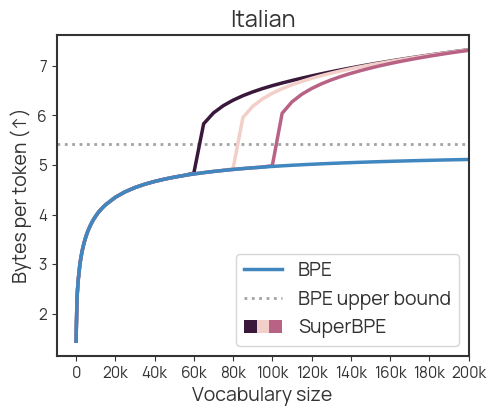

In [363]:
from matplotlib.colors import ListedColormap
from matplotlib.legend_handler import HandlerBase

# fig, ax = plt.subplots(figsize=(6.4*3/4, 4.8*3/4))
fig, ax = plt.subplots(figsize=(4.8, 4))
legend_handles = [None] * 4
legend_labels = [""] * 4
curriculum_colors = []

upper_bound = results['pretok'][float('inf')]
ax.axhline(y=upper_bound, ls='dotted', color=sns.color_palette('deep')[-3], alpha=0.8, linewidth=2)
# palette = sns.color_palette('BuPu', n_colors=len(results)+2)[2:]

for i, (label, result) in enumerate(results.items()):
    if 'curriculum' in label:
        color = sns.cubehelix_palette(start=3.26, n_colors=len(results)-1, rot=0.3, hue=1.0)[i-1]
        curriculum_colors.append(color)
    elif label == 'pretok':
        color = "#4086BF"
    elif label == 'nopretok':
        color = "#8FBC8B"
    
    plot = sns.lineplot(result, color=color, label=label, ax=ax, linewidth=2.5)
    
    # Store handles and labels for discrete lines
    if 'curriculum' not in label:        
        if label == 'pretok':
            legend_handles[0] = plot.get_lines()[-1]
            legend_labels[0] = "BPE"
        elif label == 'nopretok':
            legend_handles[1] = plot.get_lines()[-1]
            legend_labels[1] = "BPE w/o pretok"

cmap = ListedColormap(curriculum_colors)

# Custom handler to draw gradient
class GradientHandler(HandlerBase):
    def __init__(self, cmap, num_stripes=20, **kw):
        super().__init__(**kw)
        self.cmap = cmap
        self.num_stripes = num_stripes
        
    def create_artists(self, legend, orig_handle,
                      xdescent, ydescent, width, height, fontsize, trans):
        stripes = []
        for i in range(self.num_stripes):
            color = self.cmap(i / (self.num_stripes - 1))
            s = mpatches.Rectangle(
                (xdescent + width * i / self.num_stripes, ydescent),
                width / self.num_stripes,
                height,
                color=color,
                transform=trans,
                linewidth=0
            )
            stripes.append(s)
        return stripes

# Create dummy patch for gradient legend entry
gradient_patch = mpatches.Patch(facecolor='none', edgecolor='none', linewidth=0)
legend_handles[2] = gradient_patch
legend_labels[2] = 'SuperBPE'

legend_handles[1] = plot.get_lines()[0]
legend_labels[1] = 'BPE upper bound'

# Create legend with custom handler
ax.legend(
    handles=legend_handles,
    labels=legend_labels,
    handler_map={mpatches.Patch: GradientHandler(cmap, num_stripes=20)},
    fontsize=14
)
# plot.set_xscale('log')

# xticks
xticks = range(0, 200001, 20000)
ax.set_xticks(xticks)
ax.set_xticklabels([f"{tick//1000}k" if tick != 0 else "0" for tick in xticks])

ax.set_xlim(right=200000)

ax.set_xlabel('Vocabulary size')
ax.set_ylabel('Bytes per token (↑)')
ax.set_title(CODE_TO_LANG[lang])
plt.tight_layout(pad=0.1)
plt.savefig(f'plots/{lang}_pretokenization_scaling.png', dpi=300)
plt.savefig(f'plots/{lang}_pretokenization_scaling.pdf', dpi=300)

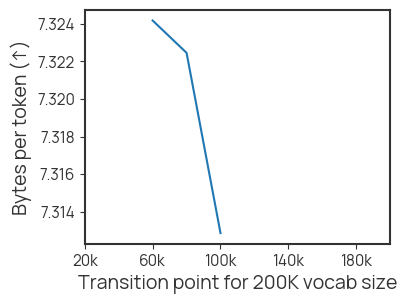

In [322]:
x, y = [], []
vocab_size = 200000

for key in results:
    if key.startswith('curriculum'):
        if vocab_size in results[key]:
            x.append(int(key.split('(')[-1].split(')')[0].replace('K', '000')))
            y.append(results[key][vocab_size])

fig, ax = plt.subplots(figsize=(6.4*3/5, 4.8*3/5))
sns.lineplot(x=x, y=y)
ax.set_xlim(right=vocab_size)

xticks = range(20000, vocab_size, 40000)
ax.set_xticks(xticks)
ax.set_xticklabels([f"{tick//1000}k" if tick != 0 else "0" for tick in xticks])

ax.set_xlabel(f'Transition point for {vocab_size // 1000}K vocab size')
ax.set_ylabel('Bytes per token (↑)')
plt.tight_layout(pad=0.1)

In [307]:
vocab_size=200000
for key in results:
    if vocab_size in results[key]:
        print(f'{key}: {results[key][vocab_size]}')

curriculum (100K): 7.116356947867946
curriculum (120K): 7.1055201215504376
curriculum (140K): 7.0596394742367385
curriculum (160K): 6.955858186550872
curriculum (180K): 6.745787058667591
pretok: 5.272745466575175


In [308]:
5.272745466575175/7.116356947867946

0.740933247896578

In [374]:
mixed_tokenizer_paths = [
    "en_pretok_10G_200K",
    "en_0.5_de_0.5",
    "en_0.5_es_0.5",
    "en_0.5_ja_0.5",
    "en_0.5_pl_0.5",
    # "en_0.5_vi_0.5",
    "en_0.5_zh_0.5"
]

results = {}
for tokenizer_path in mixed_tokenizer_paths:
    results[tokenizer_path] = get_results(tokenizer_dir=str(Path('tokenizer_json/madlad') / tokenizer_path), eval_dataset='madlad/en')

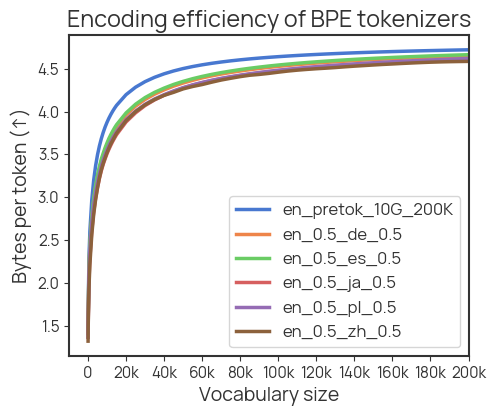

In [375]:
from matplotlib.colors import ListedColormap
from matplotlib.legend_handler import HandlerBase

fig, ax = plt.subplots(figsize=(4.8, 4))
palette = sns.color_palette('muted')

for i, (label, result) in enumerate(results.items()):
    color = palette[i % len(palette)]
    plot = sns.lineplot(result, color=color, label=label, ax=ax, linewidth=2.5)

# plot.set_xscale('log')
# xticks
xticks = range(0, 200001, 20000)
ax.set_xticks(xticks)
ax.set_xticklabels([f"{tick//1000}k" if tick != 0 else "0" for tick in xticks])

ax.set_xlim(right=200000)

ax.set_xlabel('Vocabulary size')
ax.set_ylabel('Bytes per token (↑)')
ax.set_title('Encoding efficiency of BPE tokenizers')
plt.tight_layout(pad=0.1)
plt.savefig(f'plots/mixes_efficiency_scaling.png', dpi=300)
plt.savefig(f'plots/mixes_efficiency_scaling.pdf', dpi=300)

In [250]:
results['en_0.5_es_0.5'][200000]

4.663273746410008

In [252]:
results['en_pretok_10G_200K'][120000]

4.666153819032725

In [379]:
lang1 = 'en'
lang2 = 'zh'

results = {}
tokenizer_path = f"{lang1}_0.5_{lang2}_0.5"
for lang in [lang1, lang2]:
    results[lang] = get_results(tokenizer_dir=str(Path('tokenizer_json/madlad') / tokenizer_path), eval_dataset=f'madlad/{lang}')

In [381]:
results[f'{lang1}_pretok'] = get_results(tokenizer_dir=str(Path('tokenizer_json/madlad') / f"{lang1}_pretok_10G_200K"), eval_dataset=f'madlad/{lang1}')
results[f'{lang2}_pretok'] = get_results(tokenizer_dir=str(Path('tokenizer_json/madlad') / f"{lang2}_pretok_10G_200K"), eval_dataset=f'madlad/{lang2}')

In [380]:
results[lang1][200000]

4.585145229890012

In [386]:
results[f'{lang1}_pretok'][80000]

4.603464856748782

In [387]:
results[lang2][200000]

6.363947676385878

In [392]:
results[f'{lang2}_pretok'][140000]

6.334352433513148

In [447]:
vocab_size = '200K'
train_dataset_name = f'unigram/olmo2_p99_truncate'
eval_dataset_name = 'olmo2'

compare_config = []
for v in ['1K', '5K', '10K', '20K', '40K', '60K', '80K', '100K', '120K', '140K', '160K', '180K', '200K']:
    compare_config.append(
        {
            'train_dataset': train_dataset_name,
            'train_size': '10G',
            'pretok_setting': 'pretok',
            'eval_dataset': eval_dataset_name,
            'vocab_size': v
        }
    )

unigram_results = {}

for config in compare_config:
    try:
        unigram_results[config['vocab_size']] = get_results(config)
    except FileNotFoundError:
        continue

tokenizer_json/unigram/olmo2_p99_truncate_pretok_10G_1K
tokenizer_json/unigram/olmo2_p99_truncate_pretok_10G_5K
tokenizer_json/unigram/olmo2_p99_truncate_pretok_10G_10K
tokenizer_json/unigram/olmo2_p99_truncate_pretok_10G_20K
tokenizer_json/unigram/olmo2_p99_truncate_pretok_10G_40K
tokenizer_json/unigram/olmo2_p99_truncate_pretok_10G_60K
tokenizer_json/unigram/olmo2_p99_truncate_pretok_10G_80K
tokenizer_json/unigram/olmo2_p99_truncate_pretok_10G_100K
tokenizer_json/unigram/olmo2_p99_truncate_pretok_10G_120K
tokenizer_json/unigram/olmo2_p99_truncate_pretok_10G_140K
tokenizer_json/unigram/olmo2_p99_truncate_pretok_10G_160K
tokenizer_json/unigram/olmo2_p99_truncate_pretok_10G_180K
tokenizer_json/unigram/olmo2_p99_truncate_pretok_10G_200K


In [448]:
x, y = [], []
for r in unigram_results.values():
    r.pop(float('inf'))
    x.append(list(r.keys())[0])
    y.append(list(r.values())[0])

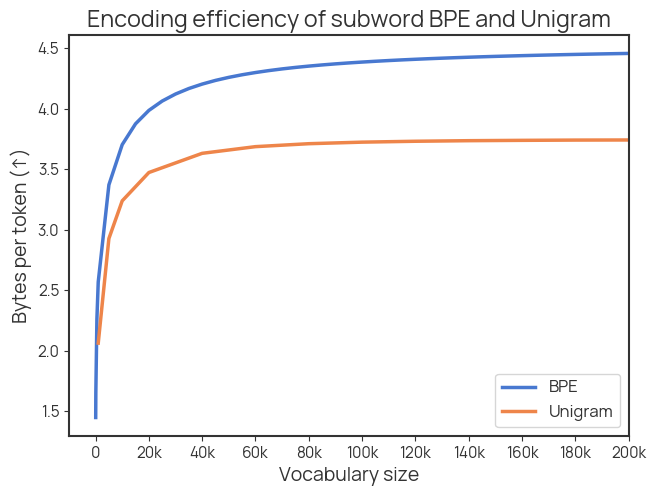

In [449]:
from matplotlib.colors import ListedColormap
from matplotlib.legend_handler import HandlerBase

fig, ax = plt.subplots()
color = sns.color_palette('muted')[0]
# upper_bound = result[float('inf')]
# ax.axhline(y=upper_bound, ls='dotted', color=color, alpha=0.5, linewidth=2)    
plot = sns.lineplot(bpe_results, color=color, ax=ax, linewidth=2.5, label='BPE')
color = sns.color_palette('muted')[1]
plot = sns.lineplot(x=x, y=y, color=color, ax=ax, linewidth=2.5, label='Unigram')

# plot.set_xscale('log')
# xticks
xticks = range(0, 200001, 20000)
ax.set_xticks(xticks)
ax.set_xticklabels([f"{tick//1000}k" if tick != 0 else "0" for tick in xticks])

ax.set_xlim(right=200000)

ax.set_xlabel('Vocabulary size')
ax.set_ylabel('Bytes per token (↑)')
ax.set_title('Encoding efficiency of subword BPE and Unigram')
plt.tight_layout(pad=0.1)
plt.savefig('plots/unigram_bpe.png', dpi=300)

In [429]:
bpe_results = get_results(tokenizer_dir='tokenizer_json/olmo2_p99_truncate_pretok_10G_200K', eval_dataset='olmo2')